In [169]:
## for data wrangling
from util_tools import *
# import util_tools
import pandas as pd
import numpy as np

## for plotting
import seaborn as sns
import matplotlib.pyplot as plt

## for reproducibility
from numpy.random import seed
import tensorflow

## for machine learning
from sklearn.model_selection import train_test_split
from scipy.stats import spearmanr,pearsonr,zscore

import xgboost as xgb

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *
from collections import Counter

# from keras.layers.embeddings import Embedding

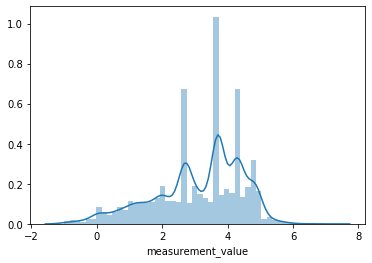

In [170]:
Counter(pd.read_csv("curated_training_data.affinity.csv").allele)
df = pd.read_csv("curated_training_data.affinity.csv").query("allele == 'HLA-A*02:01'")
seqs = df.peptide
meas = df.measurement_value
sns.distplot(meas.apply(np.log10).replace(-np.inf,0))
seqspep = seqs[[x==9 for x in map(len,seqs)]]
meas = meas[[x==9 for x in map(len,seqs)]]

In [171]:
def from_ic50(ic50, max_ic50=50000.0):
    """
    Convert ic50s to regression targets in the range [0.0, 1.0].
    
    Parameters
    ----------
    ic50 : numpy.array of float
    Returns
    -------
    numpy.array of float
    """
    x = 1.0 - (np.log(np.maximum(ic50, 1e-12)) / np.log(max_ic50))
    return np.minimum(
        1.0,
        np.maximum(0.0, x))


def to_ic50(x, max_ic50=50000.0):
    """
    Convert regression targets in the range [0.0, 1.0] to ic50s in the range
    [0, 50000.0].
    
    Parameters
    ----------
    x : numpy.array of float
    Returns
    -------
    numpy.array of float
    """
    return max_ic50 ** (1.0 - x)


In [172]:
training,testing=get_HLA_A_02_01()

local training file found... loading...
local testing file found... loading...


/home/jeron/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


### Data distribution exploration.

Take a look at the measurement values

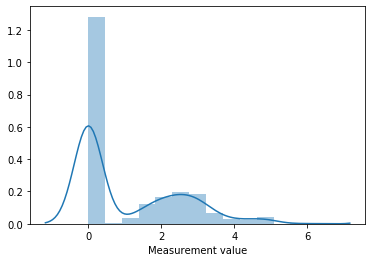

In [173]:
sns.distplot(testing.loc[:,"Measurement value"].apply(np.log10).replace(-np.inf,0))

In [174]:
# Peptide_9mers.loc[:,"meas"].max()


In [175]:
onehot = encoder("onehot")
blosum = encoder("blosum62")
reducedProp =encoder("reducedProp")
embedding =encoder("embedding")

In [176]:
Peptide_9mers = training.query("peptide_length == 9")
seqs = Peptide_9mers.loc[:,"sequence"]
off_set = Peptide_9mers["inequality"].map({"=":0,">":2,"<":4})
meas = Peptide_9mers.loc[:,"meas"].apply(np.log10)
# meas = from_ic50(Peptide_9mers.loc[:,"meas"]) +off_set
# seqs = seqspep
# Peptide_9mers
blosum_seqs = [blosum.encode(x) for x in seqs]
onehot_seqs = [onehot.encode(x) for x in seqs]
reducedProp_seqs = [reducedProp.encode(x) for x in seqs]
embedding_seqs = [embedding.encode(x) for x in seqs]

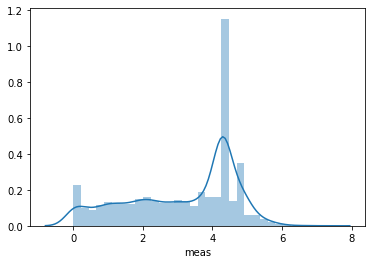

In [177]:
# sns.distplot(from_ic50(Peptide_9mers.loc[:,"meas"]))
sns.distplot(meas)
#   '=': 0,
#                 '>': 2,
#                 '<': 4,

In [251]:


def build_model(encoder_type = "blosum62", conv_layers = True, rnn= False):
    ## note: for now the RNN model only works with the embedding encoder.
    if encoder_type == "onehot":
        inputs = Input(shape=(20,9,1))
    elif encoder_type == "blosum62":
        inputs = Input(shape=(24,9,1))
    elif encoder_type == "reducedProp":
        inputs = Input(shape=(6,9,1))
    elif encoder_type == "embedding":
        inputs = Input(shape=(None,))
    
    if conv_layers:
        hidden1 = Conv2D(16,7,activation="elu",padding="same")(inputs)
        hidden2 = Conv2D(16,5,activation="elu",padding="same")(hidden1)
        hidden2  = BatchNormalization()(hidden2)
        hidden3 = Conv2D(8,5,activation="elu",padding="same")(hidden2)
        hidden4 = Conv2D(8,3,activation="elu",padding="same")(hidden3)
        hidden4  = BatchNormalization()(hidden4)
        flatten = Flatten()(hidden4)
    else:
        flatten = Flatten()(inputs)
        
    if rnn:
#         vocabulary_size, embedding_dim, input_length=max_review_length
        embeddinglayer = Embedding(input_dim=20, output_dim=64)(inputs)
        gru1 = Bidirectional(GRU(64,return_sequences=True))(embeddinglayer)
        gru2 = GRU(64)(gru1)
        flatten = Flatten()(gru2)
    
    dense1  = Dense(200,activation="relu")(flatten)
    dense1  = BatchNormalization()(dense1)
    dense1  = Dropout(0.7)(dense1)

    dense2  = Dense(200,activation="relu")(dense1)
    dense2  = BatchNormalization()(dense2)
    dense2  = Dropout(0.8)(dense2)

    dense3  = Dense(100,activation="relu")(dense2)
    dense3  = BatchNormalization()(dense3)
    dense3  = Dropout(0.8)(dense3)
    
    dense4  = Dense(50,activation="relu")(dense3)
    dense4  = BatchNormalization()(dense4)
    dense4  = Dropout(0.8)(dense4)
    
    dense5  = Dense(25,activation="relu")(dense4)
    dense5  = BatchNormalization()(dense5)
    dense5  = Dropout(0.8)(dense5)

    outputs = Dense(1,activation="linear")(dense5)

    # dense3
    model = keras.Model(inputs=inputs, outputs=outputs)
    # model.summary()

    return model

def SPRCC(y_true, y_pred):
    ## was going to use the winsorization, but commented out for now, more thoughts needed
#     from tensorflow.keras import backend as K

#     y_true = K.flatten(y_true)
#     y_pred = K.flatten(y_pred)

#     # Handle (=) inequalities
#     diff1 =  y_true
#     diff1 *= K.cast(y_true >= 0.0, "float32")
#     diff1 *= K.cast(y_true <= 1.0, "float32")

#     # Handle (>) inequalities
#     diff2 = y_true - 2.0
#     diff2 *= K.cast(y_true >= 2.0, "float32")
#     diff2 *= K.cast(y_true <= 3.0, "float32")
#     diff2 *= K.cast(diff2 > 0.0, "float32")

#     # Handle (<) inequalities
#     diff3 = y_true - 4.0
#     diff3 *= K.cast(y_true >= 4.0, "float32")
#     diff3 *= K.cast(diff3 > 0.0, "float32")
    
#     y_true = diff1 + diff2 + diff3
    
    return ( tf.py_function(spearmanr, [tf.cast(y_pred, tf.float32),tf.cast(y_true, tf.float32)], Tout = tf.float32) )

def inequaility_loss(y_true, y_pred):
    # We always delay import of Keras so that mhcflurry can be imported
    # initially without tensorflow debug output, etc.
    from tensorflow.keras import backend as K
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)

    # Handle (=) inequalities
    diff1 = y_pred - y_true
    diff1 *= K.cast(y_true >= 0.0, "float32")
    diff1 *= K.cast(y_true <= 1.0, "float32")

    # Handle (>) inequalities
    diff2 = y_pred - (y_true - 2.0)
    diff2 *= K.cast(y_true >= 2.0, "float32")
    diff2 *= K.cast(y_true <= 3.0, "float32")
    diff2 *= K.cast(diff2 > 0.0, "float32")

    # Handle (<) inequalities
    diff3 = y_pred - (y_true - 4.0)
    diff3 *= K.cast(y_true >= 4.0, "float32")
    diff3 *= K.cast(diff3 > 0.0, "float32")

    denominator = K.maximum(
        K.sum(K.cast(K.not_equal(y_true, 2.0), "float32"), 0),
        1.0)

    result = (
            K.sum(K.square(diff1)) +
            K.sum(K.square(diff2)) +
            K.sum(K.square(diff3))) / denominator

    return result

In [252]:
# ?Embedding

In [253]:
seed(123454566)
tensorflow.random.set_seed(123454566)
######### model parameters ##############
epochs = 5000
batch_size = 8
patience = 100
optimizer = "nadam"
########################################

def train_test_model(model_type = "blosum62",conv=True, rnn=False,epochs = 100, batch_size = 16, patience=2, optimizer= "nadam"):
    
    if model_type == "blosum62":
        X = np.array(blosum_seqs).reshape(-1,24,9,1)
    elif model_type == "onehot":
        X = np.array(onehot_seqs).reshape(-1,20,9,1)
    elif model_type == "reducedProp":
        X = np.array(reducedProp_seqs).reshape(-1,6,9,1)
    elif model_type == "embedding":
        X = np.array(embedding_seqs).reshape(-1,9)
#     Y = Peptide_9mers.loc[:,"meas"].apply(np.log10)
    Y = meas
    
    model = build_model(model_type,conv, rnn)
    model.compile(
#         loss=inequaility_loss,
        loss = "mse",
        optimizer=optimizer,
        metrics=[SPRCC]
    )
    es = EarlyStopping(monitor='val_loss',mode="min",patience=patience)
    mc = ModelCheckpoint('best_{}_conv={}_model.h5'.format(model_type,conv),monitor='val_loss', mode='min', save_best_only=True)
    [X_train, X_test, y_train, y_test]=train_test_split(X,Y,test_size=0.2,random_state=10)
    history = model.fit(X_train,y_train,batch_size=batch_size,epochs = epochs, validation_split=0.1,callbacks=[es,mc])
    return (history,model,X_test,y_test)

def plot_model(history=False,model=None,X_test=None,y_test=None):
    if history:
        plt.figure()
        sns.lineplot(data=pd.DataFrame(history.history).reset_index(),x="index",y="loss")
        sns.lineplot(data=pd.DataFrame(history.history).reset_index(),x="index",y="val_loss")
        plt.legend(["loss","val_loss"])
    y_pred = model.predict(X_test)
    ## transform y_test
    
#     bat1 = y_test*(y_test<=1)
#     bat2 = (y_test-2)*(y_test>=2)*(y_test<=3)
#     bat3 = (y_test-4)*(y_test>=4)
#     y_test = bat1+bat2+bat3
    plt.figure()
    sns.scatterplot(x=y_test,y=y_pred.squeeze())
    R, pv = spearmanr(y_test,y_pred.squeeze())
    plt.title("SRCC: {0:0.4f}".format(R))

In [254]:
# model_type = "onehot"
# conv=True, 
# epochs = 1 
# batch_size = 32
# patience=50
# optimizer= "nadam"
# if model_type == "blosum62":
#     X = np.array(blosum_seqs).reshape(-1,24,9,1)
# elif model_type == "onehot":
#     X = np.array(onehot_seqs).reshape(-1,20,9,1)
# elif model_type == "reducedProp":
#     X = np.array(reducedProp_seqs).reshape(-1,6,9,1)

# #     Y = Peptide_9mers.loc[:,"meas"].apply(np.log10)
# Y = meas

# model = build_model(model_type)
# model.compile(
#     loss="MSE",
#     optimizer=optimizer,
#     metrics=[SPRCC]
# )
# es = EarlyStopping(monitor='val_loss',mode="min",patience=patience)
# mc = ModelCheckpoint('best_{}_conv={}_model.h5'.format(model_type,conv),monitor='val_loss', mode='min', save_best_only=True)
# [X_train, X_test, y_train, y_test]=train_test_split(X,Y,test_size=0.2,random_state=10)

# history = model.fit(X_train,y_train,batch_size=batch_size,epochs = epochs, validation_split=0.1,callbacks=[es,mc])
# return (history,model,X_test,y_test)

In [255]:
# for x in range(50):
#     history = model.fit(X_train,y_train,batch_size=batch_size,epochs = epochs, validation_split=0.1,callbacks=[es,mc])


In [256]:
# history = model.fit(X_train,y_train,batch_size=batch_size,epochs = epochs, validation_split=0.1,callbacks=[es,mc])


Epoch 1/5000
815/815 [==============================] - 14s 17ms/step - loss: 11.3724 - SPRCC: -0.0156 - val_loss: 5.1255 - val_SPRCC: 0.0637
Epoch 2/5000
815/815 [==============================] - 13s 16ms/step - loss: 4.9594 - SPRCC: -0.0206 - val_loss: 3.1354 - val_SPRCC: 0.0539
Epoch 3/5000
815/815 [==============================] - 13s 15ms/step - loss: 3.6138 - SPRCC: -0.0124 - val_loss: 2.7394 - val_SPRCC: 0.1267
Epoch 4/5000
815/815 [==============================] - 13s 15ms/step - loss: 3.0613 - SPRCC: -1.2395e-04 - val_loss: 2.4510 - val_SPRCC: 0.0408
Epoch 5/5000
815/815 [==============================] - 12s 15ms/step - loss: 2.8291 - SPRCC: -0.0235 - val_loss: 2.3779 - val_SPRCC: 0.0961
Epoch 6/5000
815/815 [==============================] - 13s 15ms/step - loss: 2.6632 - SPRCC: -0.0062 - val_loss: 2.3488 - val_SPRCC: 0.1301
Epoch 7/5000
815/815 [==============================] - 12s 15ms/step - loss: 2.5735 - SPRCC: -0.0225 - val_loss: 2.3701 - val_SPRCC: 0.1044
Epoch 8/

/home/jeron/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/jeron/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/jeron/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home/jeron/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home/jeron/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


815/815 [==============================] - 13s 15ms/step - loss: 1.4194 - SPRCC: nan - val_loss: 0.9941 - val_SPRCC: 0.7029
Epoch 41/5000
815/815 [==============================] - 12s 15ms/step - loss: 1.3767 - SPRCC: 0.6727 - val_loss: 0.9270 - val_SPRCC: 0.7262
Epoch 42/5000
815/815 [==============================] - 12s 15ms/step - loss: 1.3753 - SPRCC: 0.6603 - val_loss: 0.9945 - val_SPRCC: 0.7023
Epoch 43/5000
815/815 [==============================] - 12s 15ms/step - loss: 1.3802 - SPRCC: 0.6739 - val_loss: 0.8644 - val_SPRCC: 0.7219
Epoch 44/5000
815/815 [==============================] - 12s 15ms/step - loss: 1.3702 - SPRCC: 0.6678 - val_loss: 0.9144 - val_SPRCC: 0.7197
Epoch 45/5000
815/815 [==============================] - 12s 15ms/step - loss: 1.3431 - SPRCC: 0.6774 - val_loss: 0.9456 - val_SPRCC: 0.7208
Epoch 46/5000
815/815 [==============================] - 12s 15ms/step - loss: 1.3966 - SPRCC: 0.6606 - val_loss: 1.0138 - val_SPRCC: 0.7233
Epoch 47/5000
815/815 [=======

Epoch 156/5000
815/815 [==============================] - 13s 16ms/step - loss: 1.0411 - SPRCC: 0.7718 - val_loss: 0.7417 - val_SPRCC: 0.7383
Epoch 157/5000
815/815 [==============================] - 13s 16ms/step - loss: 0.9878 - SPRCC: 0.7764 - val_loss: 0.7411 - val_SPRCC: 0.7479
Epoch 158/5000
815/815 [==============================] - 13s 16ms/step - loss: 1.0717 - SPRCC: 0.7626 - val_loss: 0.7274 - val_SPRCC: 0.7247
Epoch 159/5000
815/815 [==============================] - 13s 16ms/step - loss: 1.0540 - SPRCC: 0.7744 - val_loss: 0.7778 - val_SPRCC: 0.7312
Epoch 160/5000
815/815 [==============================] - 13s 16ms/step - loss: 1.0117 - SPRCC: 0.7770 - val_loss: 0.7513 - val_SPRCC: 0.7449
Epoch 161/5000
815/815 [==============================] - 13s 16ms/step - loss: 1.0119 - SPRCC: 0.7753 - val_loss: 0.7576 - val_SPRCC: 0.7375
Epoch 162/5000
815/815 [==============================] - 13s 16ms/step - loss: 1.0223 - SPRCC: 0.7700 - val_loss: 0.7283 - val_SPRCC: 0.7363
Epoch 

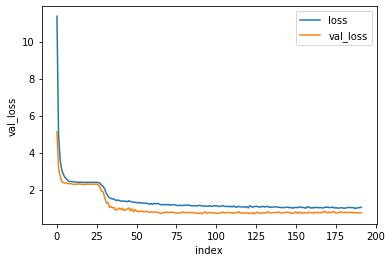

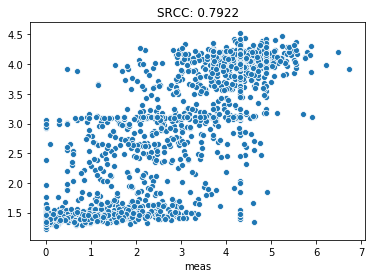

In [257]:
seed(123454566)
tensorflow.random.set_seed(123454566)

history,model,X_test,y_test = train_test_model(model_type = "embedding",
                                               conv=False,
                                               rnn = True,
                                               epochs = epochs, 
                                               batch_size = batch_size, 
                                               patience=patience, 
                                               optimizer= optimizer)
plot_model(history,model,X_test,y_test)

Epoch 1/5000
815/815 [==============================] - 8s 10ms/step - loss: 11.3621 - SPRCC: -0.0248 - val_loss: 3.9532 - val_SPRCC: -0.0180
Epoch 2/5000
815/815 [==============================] - 8s 10ms/step - loss: 4.8433 - SPRCC: 0.0132 - val_loss: 2.7212 - val_SPRCC: -0.0547
Epoch 3/5000
815/815 [==============================] - 8s 10ms/step - loss: 3.6089 - SPRCC: 0.0087 - val_loss: 2.5628 - val_SPRCC: -0.0428
Epoch 4/5000
815/815 [==============================] - 8s 10ms/step - loss: 3.0596 - SPRCC: 0.0097 - val_loss: 2.4028 - val_SPRCC: -0.0038
Epoch 5/5000
815/815 [==============================] - 8s 10ms/step - loss: 2.8494 - SPRCC: -0.0116 - val_loss: 2.3633 - val_SPRCC: 0.0790
Epoch 6/5000
815/815 [==============================] - 8s 10ms/step - loss: 2.6428 - SPRCC: 0.0118 - val_loss: 2.3178 - val_SPRCC: 0.0417
Epoch 7/5000
815/815 [==============================] - 8s 10ms/step - loss: 2.5581 - SPRCC: -0.0064 - val_loss: 2.3535 - val_SPRCC: 0.0752
Epoch 8/5000
815/81

/home/jeron/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/jeron/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/jeron/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home/jeron/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home/jeron/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


815/815 [==============================] - 8s 10ms/step - loss: 2.3875 - SPRCC: nan - val_loss: 2.2911 - val_SPRCC: 0.0476
Epoch 41/5000
815/815 [==============================] - 8s 10ms/step - loss: 2.3864 - SPRCC: 0.0091 - val_loss: 2.2905 - val_SPRCC: 0.0364
Epoch 42/5000
815/815 [==============================] - 8s 10ms/step - loss: 2.3877 - SPRCC: 0.0123 - val_loss: 2.2904 - val_SPRCC: 0.0889
Epoch 43/5000
815/815 [==============================] - 8s 10ms/step - loss: 2.3862 - SPRCC: -0.0068 - val_loss: 2.2948 - val_SPRCC: -0.0588
Epoch 44/5000
815/815 [==============================] - 8s 10ms/step - loss: 2.3863 - SPRCC: 0.0024 - val_loss: 2.2902 - val_SPRCC: 0.0117
Epoch 45/5000
815/815 [==============================] - 8s 10ms/step - loss: 2.3869 - SPRCC: -0.0187 - val_loss: 2.2953 - val_SPRCC: 0.0918
Epoch 46/5000
815/815 [==============================] - 8s 10ms/step - loss: 2.3883 - SPRCC: -0.0139 - val_loss: 2.2910 - val_SPRCC: 0.0869
Epoch 47/5000
815/815 [==========

815/815 [==============================] - 8s 10ms/step - loss: 1.9419 - SPRCC: 0.4457 - val_loss: 1.6320 - val_SPRCC: 0.5300
Epoch 157/5000
815/815 [==============================] - 8s 10ms/step - loss: 1.8702 - SPRCC: 0.4779 - val_loss: 1.5669 - val_SPRCC: 0.5442
Epoch 158/5000
815/815 [==============================] - 8s 10ms/step - loss: 1.8795 - SPRCC: 0.4720 - val_loss: 1.5585 - val_SPRCC: 0.5545
Epoch 159/5000
815/815 [==============================] - 8s 10ms/step - loss: 1.8489 - SPRCC: 0.4892 - val_loss: 1.5434 - val_SPRCC: 0.5673
Epoch 160/5000
815/815 [==============================] - 8s 10ms/step - loss: 1.8129 - SPRCC: 0.4991 - val_loss: 1.5098 - val_SPRCC: 0.5720
Epoch 161/5000
815/815 [==============================] - 8s 10ms/step - loss: 1.7920 - SPRCC: 0.5141 - val_loss: 1.5101 - val_SPRCC: 0.5807
Epoch 162/5000
815/815 [==============================] - 8s 10ms/step - loss: 1.7974 - SPRCC: 0.5108 - val_loss: 1.5096 - val_SPRCC: 0.5674
Epoch 163/5000
815/815 [====

815/815 [==============================] - 8s 10ms/step - loss: 1.1458 - SPRCC: 0.7522 - val_loss: 0.7628 - val_SPRCC: 0.7363
Epoch 273/5000
815/815 [==============================] - 8s 10ms/step - loss: 1.1184 - SPRCC: 0.7470 - val_loss: 0.7672 - val_SPRCC: 0.7307
Epoch 274/5000
815/815 [==============================] - 8s 10ms/step - loss: 1.1633 - SPRCC: 0.7375 - val_loss: 0.7909 - val_SPRCC: 0.7321
Epoch 275/5000
815/815 [==============================] - 8s 10ms/step - loss: 1.1649 - SPRCC: 0.7384 - val_loss: 0.7755 - val_SPRCC: 0.7339
Epoch 276/5000
815/815 [==============================] - 8s 10ms/step - loss: 1.1396 - SPRCC: 0.7498 - val_loss: 0.7774 - val_SPRCC: 0.7296
Epoch 277/5000
815/815 [==============================] - 8s 10ms/step - loss: 1.1323 - SPRCC: 0.7535 - val_loss: 0.7878 - val_SPRCC: 0.7201
Epoch 278/5000
815/815 [==============================] - 8s 10ms/step - loss: 1.1310 - SPRCC: 0.7459 - val_loss: 0.7937 - val_SPRCC: 0.7187
Epoch 279/5000
815/815 [====

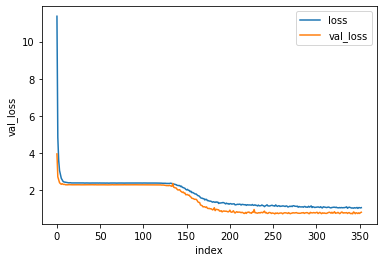

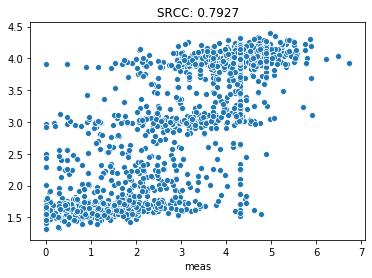

In [95]:
seed(123454566)
tensorflow.random.set_seed(123454566)

history,model,X_test,y_test = train_test_model(model_type = "onehot",
                                               conv=True, 
                                               epochs = epochs, 
                                               batch_size = batch_size, 
                                               patience=patience, 
                                               optimizer= optimizer)
plot_model(history,model,X_test,y_test)

Epoch 1/5000
815/815 [==============================] - 5s 6ms/step - loss: 11.6491 - SPRCC: -0.0203 - val_loss: 4.0788 - val_SPRCC: 0.0145
Epoch 2/5000
815/815 [==============================] - 5s 6ms/step - loss: 4.9316 - SPRCC: 0.0027 - val_loss: 2.7960 - val_SPRCC: -0.2258
Epoch 3/5000
815/815 [==============================] - 5s 6ms/step - loss: 3.5810 - SPRCC: 0.0038 - val_loss: 2.5634 - val_SPRCC: -0.1151
Epoch 4/5000
815/815 [==============================] - 5s 6ms/step - loss: 3.0707 - SPRCC: 0.0145 - val_loss: 2.4014 - val_SPRCC: 0.1228
Epoch 5/5000
815/815 [==============================] - 5s 6ms/step - loss: 2.8589 - SPRCC: -0.0122 - val_loss: 2.3492 - val_SPRCC: 0.2241
Epoch 6/5000
815/815 [==============================] - 5s 6ms/step - loss: 2.6469 - SPRCC: 0.0157 - val_loss: 2.3127 - val_SPRCC: 0.3267
Epoch 7/5000
815/815 [==============================] - 5s 6ms/step - loss: 2.5457 - SPRCC: 0.0074 - val_loss: 2.3620 - val_SPRCC: 0.2811
Epoch 8/5000
815/815 [=======

/home/jeron/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/jeron/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/jeron/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home/jeron/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home/jeron/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


815/815 [==============================] - 5s 6ms/step - loss: 1.5082 - SPRCC: nan - val_loss: 1.0867 - val_SPRCC: 0.6710
Epoch 41/5000
815/815 [==============================] - 5s 6ms/step - loss: 1.4853 - SPRCC: 0.6277 - val_loss: 1.0659 - val_SPRCC: 0.6739
Epoch 42/5000
815/815 [==============================] - 5s 6ms/step - loss: 1.4868 - SPRCC: 0.6181 - val_loss: 1.0802 - val_SPRCC: 0.6615
Epoch 43/5000
815/815 [==============================] - 5s 6ms/step - loss: 1.4700 - SPRCC: 0.6367 - val_loss: 1.0679 - val_SPRCC: 0.6909
Epoch 44/5000
815/815 [==============================] - 5s 6ms/step - loss: 1.4642 - SPRCC: 0.6287 - val_loss: 1.0595 - val_SPRCC: 0.6793
Epoch 45/5000
815/815 [==============================] - 5s 6ms/step - loss: 1.4722 - SPRCC: 0.6360 - val_loss: 1.0008 - val_SPRCC: 0.6576
Epoch 46/5000
815/815 [==============================] - 5s 6ms/step - loss: 1.4779 - SPRCC: 0.6369 - val_loss: 1.0220 - val_SPRCC: 0.6716
Epoch 47/5000
815/815 [=====================

815/815 [==============================] - 5s 6ms/step - loss: 1.1828 - SPRCC: 0.7160 - val_loss: 1.0034 - val_SPRCC: 0.6793
Epoch 100/5000
815/815 [==============================] - 5s 6ms/step - loss: 1.1843 - SPRCC: 0.7109 - val_loss: 1.0445 - val_SPRCC: 0.6816
Epoch 101/5000
815/815 [==============================] - 5s 6ms/step - loss: 1.2012 - SPRCC: 0.7214 - val_loss: 0.9867 - val_SPRCC: 0.6825
Epoch 102/5000
815/815 [==============================] - 5s 6ms/step - loss: 1.1650 - SPRCC: 0.7208 - val_loss: 0.9481 - val_SPRCC: 0.6933
Epoch 103/5000
815/815 [==============================] - 5s 6ms/step - loss: 1.1662 - SPRCC: 0.7202 - val_loss: 0.9687 - val_SPRCC: 0.6857
Epoch 104/5000
815/815 [==============================] - 5s 6ms/step - loss: 1.1568 - SPRCC: 0.7288 - val_loss: 0.9398 - val_SPRCC: 0.6813
Epoch 105/5000
815/815 [==============================] - 5s 6ms/step - loss: 1.1921 - SPRCC: 0.7197 - val_loss: 0.9674 - val_SPRCC: 0.6980
Epoch 106/5000
815/815 [===========

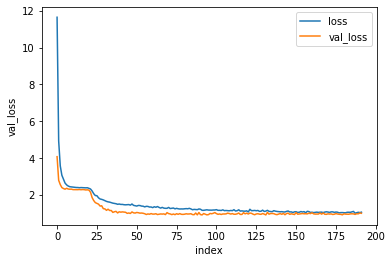

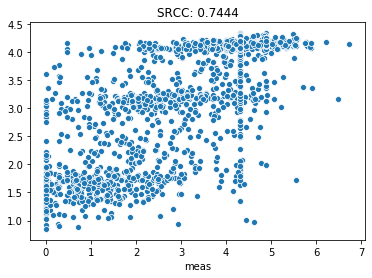

In [96]:
seed(123454566)
tensorflow.random.set_seed(123454566)

history,model,X_test,y_test = train_test_model(model_type = "reducedProp",
                                               conv=True, 
                                               epochs = epochs, 
                                               batch_size = batch_size, 
                                               patience=patience, 
                                               optimizer= optimizer)
plot_model(history,model,X_test,y_test)

Epoch 1/5000
815/815 [==============================] - 3s 4ms/step - loss: 10.6330 - SPRCC: -0.0078 - val_loss: 4.0417 - val_SPRCC: 0.2943
Epoch 2/5000
815/815 [==============================] - 3s 3ms/step - loss: 4.6035 - SPRCC: -0.0076 - val_loss: 2.8001 - val_SPRCC: 0.2864
Epoch 3/5000
815/815 [==============================] - 3s 3ms/step - loss: 3.5138 - SPRCC: -0.0066 - val_loss: 2.5542 - val_SPRCC: 0.2102
Epoch 4/5000
815/815 [==============================] - 3s 3ms/step - loss: 3.0332 - SPRCC: 0.0162 - val_loss: 2.4496 - val_SPRCC: 0.2470
Epoch 5/5000
815/815 [==============================] - 3s 3ms/step - loss: 2.8349 - SPRCC: -0.0096 - val_loss: 2.3660 - val_SPRCC: 0.3049
Epoch 6/5000
815/815 [==============================] - 3s 3ms/step - loss: 2.6661 - SPRCC: 0.0124 - val_loss: 2.3174 - val_SPRCC: 0.2875
Epoch 7/5000
815/815 [==============================] - 3s 3ms/step - loss: 2.5471 - SPRCC: 0.0056 - val_loss: 2.3697 - val_SPRCC: 0.3604
Epoch 8/5000
815/815 [=======

/home/jeron/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/jeron/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/jeron/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home/jeron/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home/jeron/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


815/815 [==============================] - 3s 3ms/step - loss: 1.3402 - SPRCC: nan - val_loss: 0.8236 - val_SPRCC: 0.7290
Epoch 41/5000
815/815 [==============================] - 3s 3ms/step - loss: 1.3056 - SPRCC: 0.6783 - val_loss: 0.8239 - val_SPRCC: 0.7276
Epoch 42/5000
815/815 [==============================] - 3s 3ms/step - loss: 1.3140 - SPRCC: 0.6840 - val_loss: 0.8185 - val_SPRCC: 0.7278
Epoch 43/5000
815/815 [==============================] - 3s 3ms/step - loss: 1.3459 - SPRCC: 0.6802 - val_loss: 0.7918 - val_SPRCC: 0.7337
Epoch 44/5000
815/815 [==============================] - 3s 3ms/step - loss: 1.3077 - SPRCC: 0.6826 - val_loss: 0.8317 - val_SPRCC: 0.7220
Epoch 45/5000
815/815 [==============================] - 3s 3ms/step - loss: 1.3117 - SPRCC: 0.6910 - val_loss: 0.7298 - val_SPRCC: 0.7160
Epoch 46/5000
815/815 [==============================] - 3s 3ms/step - loss: 1.3588 - SPRCC: 0.6755 - val_loss: 0.8468 - val_SPRCC: 0.7354
Epoch 47/5000
815/815 [=====================

815/815 [==============================] - 3s 3ms/step - loss: 1.2490 - SPRCC: 0.7022 - val_loss: 0.7194 - val_SPRCC: 0.7292
Epoch 100/5000
815/815 [==============================] - 3s 3ms/step - loss: 1.2727 - SPRCC: 0.6893 - val_loss: 0.7326 - val_SPRCC: 0.7341
Epoch 101/5000
815/815 [==============================] - 3s 3ms/step - loss: 1.2574 - SPRCC: 0.7070 - val_loss: 0.7167 - val_SPRCC: 0.7378
Epoch 102/5000
815/815 [==============================] - 3s 3ms/step - loss: 1.2405 - SPRCC: 0.7022 - val_loss: 0.7512 - val_SPRCC: 0.7313
Epoch 103/5000
815/815 [==============================] - 3s 3ms/step - loss: 1.2177 - SPRCC: 0.7137 - val_loss: 0.7062 - val_SPRCC: 0.7319
Epoch 104/5000
815/815 [==============================] - 3s 3ms/step - loss: 1.2599 - SPRCC: 0.7026 - val_loss: 0.7113 - val_SPRCC: 0.7269
Epoch 105/5000
815/815 [==============================] - 3s 3ms/step - loss: 1.3189 - SPRCC: 0.6855 - val_loss: 0.7352 - val_SPRCC: 0.7394
Epoch 106/5000
815/815 [===========

815/815 [==============================] - 3s 3ms/step - loss: 1.2405 - SPRCC: 0.7068 - val_loss: 0.7311 - val_SPRCC: 0.7456
Epoch 216/5000
815/815 [==============================] - 3s 3ms/step - loss: 1.2121 - SPRCC: 0.7151 - val_loss: 0.7123 - val_SPRCC: 0.7500
Epoch 217/5000
815/815 [==============================] - 3s 3ms/step - loss: 1.2341 - SPRCC: 0.7074 - val_loss: 0.7088 - val_SPRCC: 0.7488
Epoch 218/5000
815/815 [==============================] - 3s 3ms/step - loss: 1.2403 - SPRCC: 0.7101 - val_loss: 0.7095 - val_SPRCC: 0.7488
Epoch 219/5000
815/815 [==============================] - 3s 3ms/step - loss: 1.2345 - SPRCC: 0.7118 - val_loss: 0.7292 - val_SPRCC: 0.7534
Epoch 220/5000
815/815 [==============================] - 3s 3ms/step - loss: 1.2233 - SPRCC: 0.7112 - val_loss: 0.7051 - val_SPRCC: 0.7516
Epoch 221/5000
815/815 [==============================] - 3s 3ms/step - loss: 1.2320 - SPRCC: 0.7111 - val_loss: 0.7579 - val_SPRCC: 0.7497
Epoch 222/5000
815/815 [===========

815/815 [==============================] - 3s 3ms/step - loss: 1.2126 - SPRCC: 0.7078 - val_loss: 0.7209 - val_SPRCC: 0.7487
Epoch 332/5000
815/815 [==============================] - 3s 3ms/step - loss: 1.2350 - SPRCC: 0.7085 - val_loss: 0.7079 - val_SPRCC: 0.7548


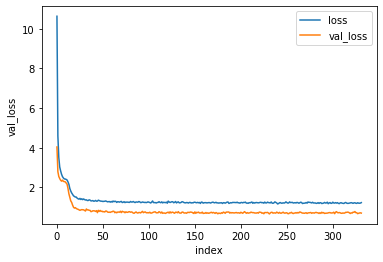

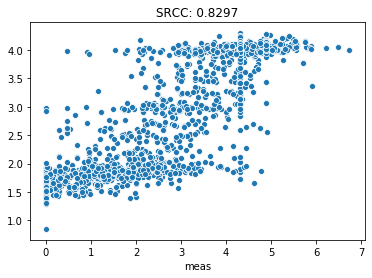

In [97]:
seed(123454566)
tensorflow.random.set_seed(123454566)

history,model,X_test,y_test = train_test_model(model_type = "blosum62",
                                               conv=False, 
                                               epochs = epochs, 
                                               batch_size = batch_size, 
                                               patience=patience, 
                                               optimizer= optimizer)
plot_model(history,model,X_test,y_test)

Epoch 1/5000
815/815 [==============================] - 3s 4ms/step - loss: 10.9907 - SPRCC: -0.0023 - val_loss: 3.9069 - val_SPRCC: -0.1164
Epoch 2/5000
815/815 [==============================] - 3s 3ms/step - loss: 4.7562 - SPRCC: -3.7226e-04 - val_loss: 2.7078 - val_SPRCC: -0.0452
Epoch 3/5000
815/815 [==============================] - 3s 3ms/step - loss: 3.5813 - SPRCC: -0.0134 - val_loss: 2.5840 - val_SPRCC: -0.0057
Epoch 4/5000
815/815 [==============================] - 3s 3ms/step - loss: 3.0680 - SPRCC: 0.0156 - val_loss: 2.4433 - val_SPRCC: -0.0309
Epoch 5/5000
815/815 [==============================] - 3s 3ms/step - loss: 2.8418 - SPRCC: -0.0137 - val_loss: 2.3528 - val_SPRCC: 0.0261
Epoch 6/5000
815/815 [==============================] - 3s 3ms/step - loss: 2.6532 - SPRCC: 0.0032 - val_loss: 2.3296 - val_SPRCC: 0.0067
Epoch 7/5000
815/815 [==============================] - 3s 3ms/step - loss: 2.5560 - SPRCC: 0.0065 - val_loss: 2.3728 - val_SPRCC: 0.1518
Epoch 8/5000
815/815 

/home/jeron/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/jeron/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/jeron/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home/jeron/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home/jeron/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


815/815 [==============================] - 3s 3ms/step - loss: 1.3168 - SPRCC: nan - val_loss: 0.8059 - val_SPRCC: 0.7259
Epoch 41/5000
815/815 [==============================] - 3s 3ms/step - loss: 1.2735 - SPRCC: 0.6833 - val_loss: 0.8176 - val_SPRCC: 0.7234
Epoch 42/5000
815/815 [==============================] - 3s 3ms/step - loss: 1.2978 - SPRCC: 0.6786 - val_loss: 0.8030 - val_SPRCC: 0.7346
Epoch 43/5000
815/815 [==============================] - 3s 3ms/step - loss: 1.3029 - SPRCC: 0.6875 - val_loss: 0.7923 - val_SPRCC: 0.7359
Epoch 44/5000
815/815 [==============================] - 3s 3ms/step - loss: 1.2476 - SPRCC: 0.6961 - val_loss: 0.7725 - val_SPRCC: 0.7350
Epoch 45/5000
815/815 [==============================] - 3s 3ms/step - loss: 1.2672 - SPRCC: 0.7025 - val_loss: 0.7156 - val_SPRCC: 0.7318
Epoch 46/5000
815/815 [==============================] - 3s 3ms/step - loss: 1.2974 - SPRCC: 0.6893 - val_loss: 0.7928 - val_SPRCC: 0.7394
Epoch 47/5000
815/815 [=====================

815/815 [==============================] - 3s 3ms/step - loss: 1.1324 - SPRCC: 0.7337 - val_loss: 0.6863 - val_SPRCC: 0.7292
Epoch 100/5000
815/815 [==============================] - 3s 3ms/step - loss: 1.1628 - SPRCC: 0.7269 - val_loss: 0.6869 - val_SPRCC: 0.7360
Epoch 101/5000
815/815 [==============================] - 3s 3ms/step - loss: 1.1547 - SPRCC: 0.7406 - val_loss: 0.7010 - val_SPRCC: 0.7442
Epoch 102/5000
815/815 [==============================] - 3s 3ms/step - loss: 1.1641 - SPRCC: 0.7262 - val_loss: 0.7086 - val_SPRCC: 0.7344
Epoch 103/5000
815/815 [==============================] - 3s 3ms/step - loss: 1.1390 - SPRCC: 0.7419 - val_loss: 0.6853 - val_SPRCC: 0.7323
Epoch 104/5000
815/815 [==============================] - 3s 3ms/step - loss: 1.1853 - SPRCC: 0.7301 - val_loss: 0.6940 - val_SPRCC: 0.7329
Epoch 105/5000
815/815 [==============================] - 3s 3ms/step - loss: 1.2071 - SPRCC: 0.7320 - val_loss: 0.6887 - val_SPRCC: 0.7345
Epoch 106/5000
815/815 [===========

815/815 [==============================] - 3s 3ms/step - loss: 1.1107 - SPRCC: 0.7592 - val_loss: 0.7050 - val_SPRCC: 0.7444
Epoch 216/5000
815/815 [==============================] - 3s 3ms/step - loss: 1.0820 - SPRCC: 0.7683 - val_loss: 0.6851 - val_SPRCC: 0.7384
Epoch 217/5000
815/815 [==============================] - 3s 3ms/step - loss: 1.0776 - SPRCC: 0.7703 - val_loss: 0.6822 - val_SPRCC: 0.7413
Epoch 218/5000
815/815 [==============================] - 3s 3ms/step - loss: 1.0980 - SPRCC: 0.7657 - val_loss: 0.6694 - val_SPRCC: 0.7464
Epoch 219/5000
815/815 [==============================] - 3s 3ms/step - loss: 1.1120 - SPRCC: 0.7626 - val_loss: 0.7248 - val_SPRCC: 0.7426
Epoch 220/5000
815/815 [==============================] - 3s 3ms/step - loss: 1.0848 - SPRCC: 0.7670 - val_loss: 0.6769 - val_SPRCC: 0.7463
Epoch 221/5000
815/815 [==============================] - 3s 3ms/step - loss: 1.1033 - SPRCC: 0.7606 - val_loss: 0.7205 - val_SPRCC: 0.7403
Epoch 222/5000
815/815 [===========

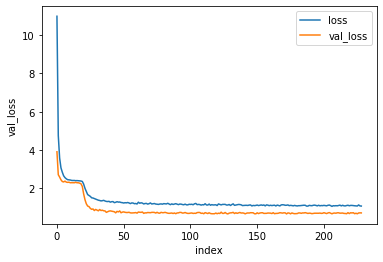

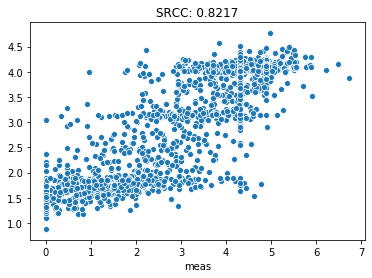

In [98]:
seed(123454566)
tensorflow.random.set_seed(123454566)

history,model,X_test,y_test = train_test_model(model_type = "onehot",
                                               conv=False, 
                                               epochs = epochs, 
                                               batch_size = batch_size, 
                                               patience=patience, 
                                               optimizer= optimizer)
plot_model(history,model,X_test,y_test)

Epoch 1/5000
815/815 [==============================] - 3s 4ms/step - loss: 11.0013 - SPRCC: -0.0155 - val_loss: 4.0239 - val_SPRCC: -0.0432
Epoch 2/5000
815/815 [==============================] - 3s 3ms/step - loss: 4.6655 - SPRCC: 0.0124 - val_loss: 2.7543 - val_SPRCC: -0.0301
Epoch 3/5000
815/815 [==============================] - 3s 3ms/step - loss: 3.5232 - SPRCC: -0.0017 - val_loss: 2.5188 - val_SPRCC: -0.1441
Epoch 4/5000
815/815 [==============================] - 3s 3ms/step - loss: 3.0751 - SPRCC: 0.0079 - val_loss: 2.4119 - val_SPRCC: 0.0955
Epoch 5/5000
815/815 [==============================] - 3s 3ms/step - loss: 2.8563 - SPRCC: -0.0145 - val_loss: 2.3524 - val_SPRCC: 0.0508
Epoch 6/5000
815/815 [==============================] - 3s 3ms/step - loss: 2.6511 - SPRCC: 0.0202 - val_loss: 2.3138 - val_SPRCC: 0.1864
Epoch 7/5000
815/815 [==============================] - 3s 3ms/step - loss: 2.5555 - SPRCC: 0.0026 - val_loss: 2.3528 - val_SPRCC: 0.2544
Epoch 8/5000
815/815 [=====

/home/jeron/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/jeron/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/jeron/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home/jeron/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home/jeron/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


815/815 [==============================] - 3s 3ms/step - loss: 1.5030 - SPRCC: nan - val_loss: 1.0152 - val_SPRCC: 0.6759
Epoch 41/5000
815/815 [==============================] - 3s 3ms/step - loss: 1.4546 - SPRCC: 0.6422 - val_loss: 1.0117 - val_SPRCC: 0.6715
Epoch 42/5000
815/815 [==============================] - 3s 3ms/step - loss: 1.4928 - SPRCC: 0.6236 - val_loss: 1.0267 - val_SPRCC: 0.6656
Epoch 43/5000
815/815 [==============================] - 3s 3ms/step - loss: 1.4854 - SPRCC: 0.6406 - val_loss: 1.0277 - val_SPRCC: 0.6721
Epoch 44/5000
815/815 [==============================] - 3s 3ms/step - loss: 1.4707 - SPRCC: 0.6364 - val_loss: 1.0265 - val_SPRCC: 0.6853
Epoch 45/5000
815/815 [==============================] - 3s 3ms/step - loss: 1.4726 - SPRCC: 0.6395 - val_loss: 0.9265 - val_SPRCC: 0.6808
Epoch 46/5000
815/815 [==============================] - 3s 3ms/step - loss: 1.5011 - SPRCC: 0.6322 - val_loss: 1.0321 - val_SPRCC: 0.6824
Epoch 47/5000
815/815 [=====================

815/815 [==============================] - 3s 3ms/step - loss: 1.3947 - SPRCC: 0.6582 - val_loss: 0.9018 - val_SPRCC: 0.6930
Epoch 100/5000
815/815 [==============================] - 3s 3ms/step - loss: 1.4230 - SPRCC: 0.6508 - val_loss: 0.9088 - val_SPRCC: 0.6981
Epoch 101/5000
815/815 [==============================] - 3s 3ms/step - loss: 1.4136 - SPRCC: 0.6631 - val_loss: 0.9233 - val_SPRCC: 0.6900
Epoch 102/5000
815/815 [==============================] - 3s 3ms/step - loss: 1.4033 - SPRCC: 0.6541 - val_loss: 0.9341 - val_SPRCC: 0.6952
Epoch 103/5000
815/815 [==============================] - 3s 3ms/step - loss: 1.3755 - SPRCC: 0.6681 - val_loss: 0.8974 - val_SPRCC: 0.7000
Epoch 104/5000
815/815 [==============================] - 3s 3ms/step - loss: 1.4294 - SPRCC: 0.6484 - val_loss: 0.9016 - val_SPRCC: 0.6843
Epoch 105/5000
815/815 [==============================] - 3s 3ms/step - loss: 1.4268 - SPRCC: 0.6574 - val_loss: 0.9002 - val_SPRCC: 0.6915
Epoch 106/5000
815/815 [===========

815/815 [==============================] - 3s 3ms/step - loss: 1.3464 - SPRCC: 0.6755 - val_loss: 0.8625 - val_SPRCC: 0.7043
Epoch 216/5000
815/815 [==============================] - 3s 3ms/step - loss: 1.3497 - SPRCC: 0.6786 - val_loss: 0.8517 - val_SPRCC: 0.7034
Epoch 217/5000
815/815 [==============================] - 3s 3ms/step - loss: 1.3416 - SPRCC: 0.6829 - val_loss: 0.8435 - val_SPRCC: 0.7067
Epoch 218/5000
815/815 [==============================] - 3s 3ms/step - loss: 1.3479 - SPRCC: 0.6871 - val_loss: 0.8550 - val_SPRCC: 0.7010
Epoch 219/5000
815/815 [==============================] - 3s 3ms/step - loss: 1.3425 - SPRCC: 0.6887 - val_loss: 0.8659 - val_SPRCC: 0.7004
Epoch 220/5000
815/815 [==============================] - 3s 3ms/step - loss: 1.3307 - SPRCC: 0.6854 - val_loss: 0.8433 - val_SPRCC: 0.7080
Epoch 221/5000
815/815 [==============================] - 3s 3ms/step - loss: 1.3260 - SPRCC: 0.6911 - val_loss: 0.8746 - val_SPRCC: 0.7110
Epoch 222/5000
815/815 [===========

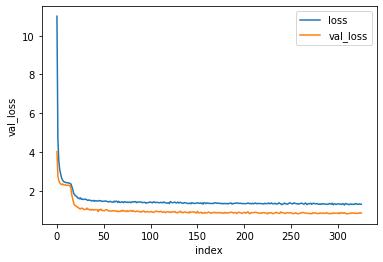

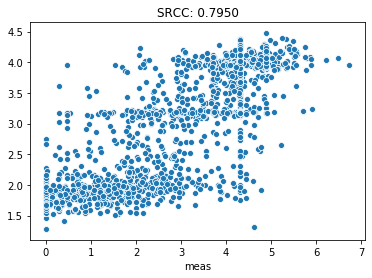

In [99]:
seed(123454566)
tensorflow.random.set_seed(123454566)

history,model,X_test,y_test = train_test_model(model_type = "reducedProp",
                                               conv=False, 
                                               epochs = epochs, 
                                               batch_size = batch_size, 
                                               patience=patience, 
                                               optimizer= optimizer)
plot_model(history,model,X_test,y_test)

In [ ]:
# plot_model(history,model,X_test,y_test)


In [ ]:
seed(123454566)
set_random_seed(123454566)

X = np.array(reducedProp_seqs).reshape(-1,54)
Y = Peptide_9mers.loc[:,"meas"].apply(np.log10)
# Y = meas.apply(np.log10)
[X_train, X_test, y_train, y_test]=train_test_split(X,Y,test_size=0.2,random_state=10)
model = xgb.XGBRegressor(n_estimators=150)

model.fit(X_train,y_train)

In [ ]:
[10**x for x in model.predict(X_test)]

In [ ]:
y_pred = model.predict(X_test)
plt.figure()
sns.scatterplot(x=y_test,y=y_pred.squeeze())
R, pv = spearmanr(y_test,y_pred.squeeze())
plt.title("SRCC: {0:0.4f}".format(R))

In [ ]:
seed(123454566)
tensorflow.random.set_seed(123454566)

X = np.array(reducedProp_seqs).reshape(-1,54)
Y = Peptide_9mers.loc[:,"meas"].apply(np.log10)
[X_train, X_test, y_train, y_test]=train_test_split(seqs,Y,test_size=0.2,random_state=10)
# X_test

In [ ]:
pep = ""
for x in X_test:
    pep += x + " "
# pep

In [ ]:
mhcflurry = list(pd.read_csv("/mnt/e/OneDrive/hobby_Project/mhcflurry_prediction.csv").mhcflurry_affinity.apply(np.log10))
sns.scatterplot(x=y_test,y=mhcflurry)
spearmanr(y_test,mhcflurry)